# NLP. Tarea 4: Modelos de lenguaje.

### *Diego Moreno*

Importamos las librerías necesarias:

In [492]:
import numpy as np
import re
from collections import Counter
import wget
from time import time
import nltk
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

## 2. Ahorcado

Importamos el texto:

In [5]:
url_pag = 'http://norvig.com/big.txt'
pth = ''
wget.download(url = url_pag, out = pth)

'big.txt'

La función del ahorcado:

In [5]:
def words(text): 
    #return re.findall(r'\w+', text.lower())
    return re.findall('[^\d\W]+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def hangman(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or 
            known(ahorcado_edit1(word)) or 
            known(ahorcado_edit2(word)) or 
            known(ahorcado_edit3(word)) or 
            known(ahorcado_edit4(word)) or 
            [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def ahorcado_edit1(word):
    "Función que trata de adivinar una palabras con hasta 4 letras faltantes"
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word)) if word[i]=='_']
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    return set(replaces)

def ahorcado_edit2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in ahorcado_edit1(word) for e2 in ahorcado_edit1(e1))

def ahorcado_edit3(word): 
    "All edits that are 3 edits away from `word`."
    return (e2 for e1 in ahorcado_edit2(word) for e2 in ahorcado_edit1(e1))

def ahorcado_edit4(word): 
    "All edits that are 4 edits away from `word`."
    return (e2 for e1 in ahorcado_edit3(word) for e2 in ahorcado_edit1(e1))

La idea de la función es realizar los splits de las palabras, solamente si se encuentra un espacio vacío. Con dicho espacio solamente se realizará la operación de reemplazo por otra letra. Con esta misma estrategia se buscarán posibles palabras reemplazando hasta 4 veces los espacios vacíos, (fácilmente extendible hasta más letras). Para palabras con más de 1 letra faltante, lo que se hace es realizar los posibles reemplazos con n-1 letras faltantes y luego hacer otro reemplazo extra.

A continuación algunos ejemplos:

In [50]:
start = time()
word = hangman('sp_l_i__')
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 3.96


'spelling'

In [81]:
start = time()
word = hangman ( "pe_p_e" )
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 0.00


'people'

In [82]:
start = time()
word = hangman ("phi__sop_y")
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 0.07


'philosophy'

In [54]:
start = time()
word = hangman ("si_nif_c_nc_")
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 4.13


'significance'

In [83]:
start = time()
word = hangman ("he__o")
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 0.00


'hello'

In [57]:
start = time()
word = hangman ("refr_g_r_t_r")
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 4.21


'refrigerator'

In [61]:
start = time()
word = hangman ("e_se__ia_")
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 4.09


'essential'

In [63]:
start = time()
word = hangman ("l__gu_ge_")
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 4.07


'languages'

In [68]:
start = time()
word = hangman ("d__ma__")
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 3.91


'denmark'

In [84]:
start = time()
word = hangman ("eu____")
end = time()
print("Tiempo en encontrar la solución: %.2f" % (end-start))
word

Tiempo en encontrar la solución: 3.86


'europe'

## 3. Modelos de lenguaje

### 3.1.1. Construcción del modelo

Leemos los datos wikitext

In [6]:
def get_text_from_file(path_corpus, path_labels):
    tr_txt = []
    tr_y = []
    
    with open(path_corpus, 'r') as f_corpus, open(path_labels, 'r') as f_labels:
        for twitt in f_corpus:
            tr_txt += [twitt]
        for label in f_labels:
            tr_y += [label]
    return tr_txt, tr_y

def sort_freq_dict(fdict):
    aux = [(fdict[key], key) for key in fdict]
    aux.sort()
    aux.reverse()
    return aux

In [7]:
def words_with_points(text): 
    return re.findall('[^\d\W]+|[\x2E]', text.lower())

In [281]:
pth = 'wikitext-2/'
WIKIWORDS_tr = words_with_points(open(pth + 'wiki.train.tokens').read())
WIKIWORDS_va = words_with_points(open(pth + 'wiki.valid.tokens').read())
WIKIWORDS_te = words_with_points(open(pth + 'wiki.test.tokens').read())
WORDS        = words_with_points(open('big.txt').read())

Se decide que se van a utilizar un corpus como una lista gigante con las palabras porque es más fácil ordenar la seecuencia y hacer en un futuro los paddings para los bigramas y trigramas. Es por ello que a contunuación se colocarán los tokens de inicio, fin y palabra desconocida para el vocabulario. La estrategia será filtrar las palabras a solo minúsculas y dejando los puntos como signo de fin de oración, nosotros lo reemplazamos por los tokens correspondientes.

In [282]:
corpus = []
validation = []
test = []

Agregamos WORDS al corpus:

In [283]:
WORDS = ['<s>']+WORDS
for i in range(len(WORDS)):
    if WORDS[i] == '.':
        corpus += ['</s>', '<s>'] 
    else:
        corpus += [WORDS[i]]
corpus += ['</s>', '<s>'] 

Agregamos las WIKIWORDS al corpus:

In [284]:
for i in range(len(WIKIWORDS_tr)):
    if WIKIWORDS_tr[i] == '.':
        corpus += ['</s>', '<s>'] 
    elif WIKIWORDS_tr[i] == 'unk':
        corpus += ['<unk>']
    else:
        corpus += [WIKIWORDS_tr[i]]
corpus = corpus[:(-1)]

Ahora para validación y test:

In [285]:
for i in range(len(WIKIWORDS_va)):
    if WIKIWORDS_va[i] == '.':
        validation += ['</s>', '<s>'] 
    elif WIKIWORDS_va[i] == 'unk':
        validation += ['<unk>']
    else:
        validation += [WIKIWORDS_va[i]]
validation = ['<s>'] + validation + ['</s>']

for i in range(len(WIKIWORDS_te)):
    if WIKIWORDS_te[i] == '.':
        test += ['</s>', '<s>'] 
    elif WIKIWORDS_te[i] == 'unk':
        test += ['<unk>']
    else:
        test += [WIKIWORDS_te[i]]
test = ['<s>'] + test[:(-1)]

Definimos vocabulario:

In [286]:
v = sort_freq_dict(Counter(corpus)) 
V = v[:10000]

dict_ind = {}
dict_ind_inv = {}
count = 0
for _, word in V:
    dict_ind[word] = count
    dict_ind_inv[count] = word
    count += 1

In [432]:
for i in range(len(corpus)):
    if not (corpus[i] in dict_ind):
        corpus[i] = '<unk>'
for i in range(len(validation)):
    if not (validation[i] in dict_ind):
        validation[i] = '<unk>'
for i in range(len(test)):
    if not (test[i] in dict_ind):
        test[i] = '<unk>'

Vemos cual es el porcentaje de palabras desconocidas en nuestro corpus:

In [433]:
V[dict_ind['<unk>']][0]/len(corpus)*100

1.7722006043487937

Alrededor del 2% de palabras desconocidas, el cual es un buen número para trabajar

### 3.1.2 Entrenamiento del modelo de lenguaje

#### Unigramas: 
Solo se toma en cuenta una palabra por lo que la probabilidad es la frecuencia de ella entre el total de las palabras. Como para los trigramas vamos a usar bigramas que no se han visto, como en el trigrama ('\<s\>', '\<s\>', 'the'), el bigrama ('\<s\>', '\<s\>') nunca se ve y tendrá probabilidad 0, así que vamos a entrenar los modelos con el suavizamiento Laplaciano:

In [388]:
P_uni = {}
N = len(corpus)
len_V = len(V)
for frec, word in V:
    P_uni[word] = (frec+1) / (N+len_V)

Ejemplos:

In [389]:
P_uni['holmes']

0.00015554634278533376

In [390]:
P_uni['<s>']

0.04594308620759907

In [391]:
P_uni['the']

0.068096960022973

In [392]:
P_uni['<unk>']

0.017665019794161418

#### Bigramas: 
Creamos los bigramas:
Al principio no se contaba el bigrama ('\</s\>, \<s\>'), pero como realizamos el suavizamiento Laplaciano, el bigrama mencionado anteriormente sí aparece en la secuencia por lo que debe ser contabilizado.

In [393]:
bigrams = [('<s>', '<s>')]
end = dict_ind['</s>']
for i in range(1, len(corpus)):
    #if dict_ind[corpus[i-1]] != end:
    bigrams.append((corpus[i-1], corpus[i]))
bigrams += [('</s>', '</s>')]

Probabilidades:

In [415]:
def P_bigr(bigram, freq={}, freqU={}, cond=False):
    if cond:
        if bigram not in freq:
            return 1 / (freqU[bigram[0]]+len_V)
        return (freq[bigram]+1) / (freqU[bigram[0]]+len_V)
    
    else:
        ans = np.log(P_uni[bigram[1]])
        ans += np.log((freq[bigram]+1) / (freqU[bigram[0]]+len_V))
        return  np.exp(ans)

In [416]:
freqBigr = Counter(bigrams)
freqUni = Counter(corpus)

Ejemplos:

In [417]:
bigram = bigrams[1]
print('P', bigram)
print(P_bigr(bigram, freqBigr, freqUni))
print('\nP(', bigram[1],'|',bigram[0],')')
print(P_bigr(bigram, freqBigr, freqUni, cond=True))

P ('<s>', 'the')
0.009129748280057698

P( the | <s> )
0.13406983625961727


In [418]:
bigram = bigrams[33]
print('P', bigram)
print(P_bigr(bigram, freqBigr, freqUni))
print('\nP(', bigram[1],'|',bigram[0],')')
print(P_bigr(bigram, freqBigr, freqUni, cond=True))

P ('</s>', '<s>')
0.042921906079526534

P( <s> | </s> )
0.9342408101532189


Notamos que la probabilidad de que siga un token de inicio despues de uno de final es muy alta, por lo que es un indicio de que las cosas van por buen camino.

In [419]:
bigram = ('holmes','sherlock')
print('P', bigram)
print(P_bigr(bigram, freqBigr, freqUni))
print('\nP(', bigram[1],'|',bigram[0],')')
print(P_bigr(bigram, freqBigr, freqUni, cond=True))

P ('holmes', 'sherlock')
3.3325540423132625e-09

P( sherlock | holmes )
9.541984732824427e-05


In [420]:
bigram = ('sherlock','holmes')
print('P', bigram)
print(P_bigr(bigram, freqBigr, freqUni))
print('\nP(', bigram[1],'|',bigram[0],')')
print(P_bigr(bigram, freqBigr, freqUni, cond=True))

P ('sherlock', 'holmes')
1.6467259006659472e-06

P( holmes | sherlock )
0.01058672207381023


Otro indicio bueno es que el bigrama holmes-sherlock no aparece en el copus y con el suavizamiento le damos una probabilidad. Por el lado contrario, la probabilidad de que aparezca la palabra holmes dado que apareció sherlock es de 0.01 mucho más probable que la de holmes-sherlock.

#### Trigramas:
creamos los trigramas, tenemos que aumentar un token extra como padding en el inicio y final de cada oración:

In [402]:
trigrams = [('<s>', '<s>', '<s>')]
start = dict_ind['<s>']
end = dict_ind['</s>']
for i in range(2, len(corpus)):
    if dict_ind[corpus[i-2]] == start:
        trigrams += [('<s>', '<s>', corpus[i-1])]
    if dict_ind[corpus[i-1]] == end:
        trigrams.append((corpus[i-2], '</s>', '</s>'))
    elif dict_ind[corpus[i-2]] != end:
        trigrams.append((corpus[i-2], corpus[i-1], corpus[i]))
trigrams += [('</s>', '</s>', '</s>')]

Probabilidades:

In [424]:
def P_trigr(trigram, freq={}, freqB={}, freqU={}, cond=False):
    '''
    Función que calcula la probabilidad de los trigramas.
    Notar que aquí se debe usar el tamaño del vocabulario de los
    bigramas en el suavizamiento Laplaciano, no el tamño del 
    vocabulario de palabras. No dice en el libro pero es intuición.
    '''
    lenVB = len(freqB)
    if cond:
        if trigram not in freq:
            return 1 / (freqB[(trigram[0],trigram[1])] + lenVB)
        return (freq[trigram]+1) / (freqB[(trigram[0],trigram[1])] + lenVB)
    
    else:
        ans = np.log(P_uni[trigram[2]])
        ans += np.log(P_bigr((trigram[1],trigram[2]), freqB, freqU, True))
        ans += np.log((freq[trigram]+1) / (freqB[(trigram[0],trigram[1])] + lenVB))
        return  np.exp(ans)

In [425]:
freqTrigr = Counter(trigrams)

Ejemplos:

In [426]:
trigram = trigrams[1]
print('P', trigram)
print(P_trigr(trigram, freqTrigr, freqBigr, freqUni))
print('\nP(', trigram[2],'|',trigram[0],trigram[1],')')
print(P_trigr(trigram, freqTrigr, freqBigr, freqUni, cond=True))

P ('<s>', '<s>', 'the')
0.0003150517639765688

P( the | <s> <s> )
0.034508264008192076


In [427]:
trigram = ('how', 'are', 'you')
print('P', trigram)
print(P_trigr(trigram, freqTrigr, freqBigr, freqUni))
print('\nP(', trigram[2],'|',trigram[0],trigram[1],')')
print(P_trigr(trigram, freqTrigr, freqBigr, freqUni, cond=True))

P ('how', 'are', 'you')
6.692910125256305e-10

P( you | how are )
2.8772984537059604e-05


#### 3.1.3 Interpolación y EM para los parámetros
Función de EM con la que vamos a trabajar:

In [519]:
def perplexity(trigrams, lm=1, interpol=False):
    '''
    Función de la perplexidad para trigramas
    '''
    N = len(trigrams)
    ans = 1.
    for i in range(N):
        if interpol:
            p  = lm[0] * P_uni[trigram[2]]
            p += lm[1] * P_bigr((trigram[1],trigram[2]), freqBigr, freqUni, cond=True)
            p += lm[2] * P_trigr(trigram, freqTrigr, freqBigr, freqUni, cond=True)
        else:
            p  = P_trigr(trigram, freqTrigr, freqBigr, freqUni, cond=True)
        ans /= p**(1/N)
    return ans
    
def EM_trigrams(lm, val_trigrams, N_max=1000):
    '''
    Función que encuentra los mejores parámetros lambda para
    la probabilidad de los trigramas usando datos de validación.
    '''
    perp  = [perplexity(val_trigrams, interpol=False)]
    perp += [perplexity(val_trigrams, lm, interpol=True)]
    for i in range(N_max):
        q_m = []
        for trigram in val_trigrams:
            q  = [lm[0] * P_uni[trigram[2]]]
            q += [lm[1] * P_bigr((trigram[1],trigram[2]), freqBigr, freqUni, cond=True)]
            q += [lm[2] * P_trigr(trigram, freqTrigr, freqBigr, freqUni, cond=True)]
            q_m += [normalize(np.array([q]), axis=1)[0]]
        aux = np.mean(q_m, axis=0)
        if (aux == lm).all():
            break
        else:
            lm = aux
            perp += [perplexity(val_trigrams, lm, interpol=True)]
    return lm, perp

Trigramas de validación:

In [496]:
val_trigr = []
start = dict_ind['<s>']
end = dict_ind['</s>']
for i in range(2, len(validation)):
    if dict_ind[validation[i-2]] == start:
        val_trigr += [('<s>', '<s>', validation[i-1])]
    if dict_ind[validation[i-1]] == end:
        val_trigr.append((validation[i-2], '</s>', '</s>'))
    elif dict_ind[validation[i-2]] != end:
        val_trigr.append((validation[i-2], validation[i-1], validation[i]))

A continuación, en lugar de probar con $\lambda$'s distintas y comparar su perplexidad entre ellas, ya vamos a probar las $\lambda$'s encontradas con el algoritmo de EM. Con el algoritmoo de EM convergemos a una solución, sin embargo, nos faltaría explorar los puntos iniciales por los que podemos empezar a encontrar la solución y no estancarnos en máximos locales:

Prueba 1:

In [520]:
#Lambda inicial
lm_i = [1/3, 1/3, 1/3]
lm_f, perps = EM_trigrams(lm_i, val_trigr, 10)
print('Lambda encontrado:',lm_f)

Lambda encontrado: [5.49431225e-01 6.58872268e-01 1.90851475e-14]


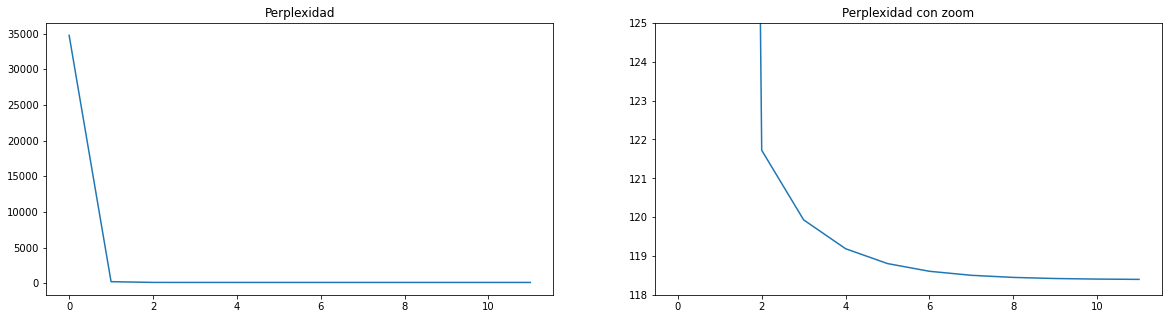

In [521]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(perps)
plt.title('Perplexidad')

plt.subplot(122)
plt.plot(perps)
plt.ylim((118,125))
plt.title('Perplexidad con zoom')
plt.show()

La perplexidad baja y se estnaca a un valor aproximadamente 118.4 el cual es bastante mejor que la perplexidad inicial de 35000.

Probemos con otro punto inicial:

In [522]:
#Lambda inicial
lm_i = [5, 4, 1]
lm_f2, perps2 = EM_trigrams(lm_i, val_trigr, 10)
print('Lambda encontrado:',lm_f2)

Lambda encontrado: [5.49557105e-01 6.58774887e-01 4.58792527e-15]


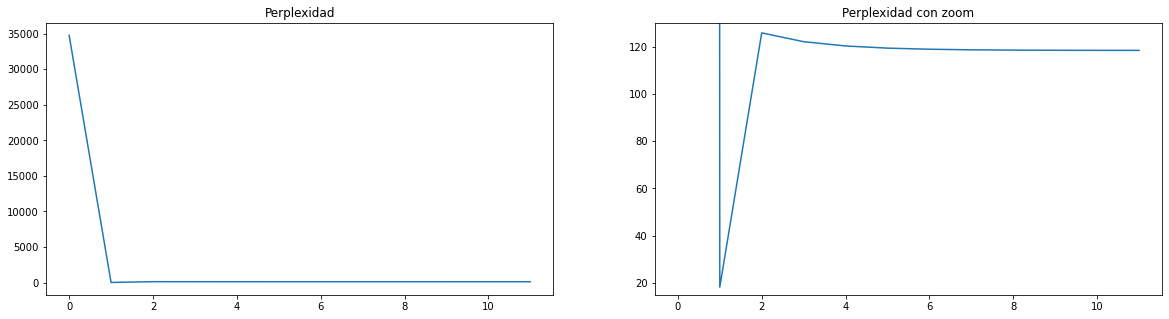

In [530]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(perps2)
plt.title('Perplexidad')

plt.subplot(122)
plt.plot(perps2)
plt.ylim((15,130))
plt.title('Perplexidad con zoom')
plt.show()

Similarmente, esta baja bruscamente a perplexidad 20 pero el algoritmo EM hace que luego suba y se estanca en el mismo valor de la perplexidad, puede ser indicio de que es la más baja. Esto nos quiere decir que tomar más en cuenta la probabilidad de una palabra, luego la del bigrama y por último la del trigrama puede ser mejor para el modelo debido a que la iteracion 1 corresponde al $\lambda$ inicial.

Probemos el último punto inicial:

In [524]:
#Lambda inicial
lm_i = [.1, .4, .5]
lm_f3, perps3 = EM_trigrams(lm_i, val_trigr, 10)
print('Lambda encontrado:',lm_f3)

Lambda encontrado: [5.48766583e-01 6.59386187e-01 3.41067905e-14]


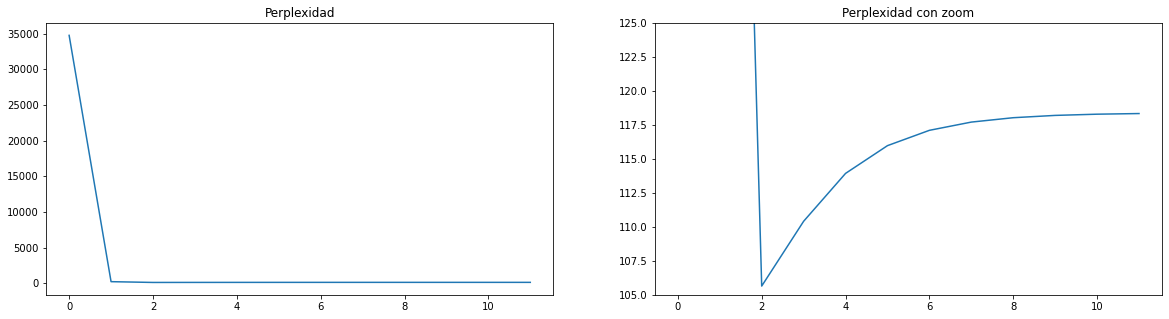

In [525]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(perps3)
plt.title('Perplexidad')

plt.subplot(122)
plt.plot(perps3)
plt.ylim((105,125))
plt.title('Perplexidad con zoom')
plt.show()

Con este punto inicial, al primer paso se logra bajar mucho la perplexidad, sin embargo, el algoritmo EM hace que suba y converja nuevamente al 118.

Finalmente lo probamos con los datos en test:

Trigramas de test:

In [531]:
test_trigr = []
start = dict_ind['<s>']
end = dict_ind['</s>']
for i in range(2, len(test)):
    if dict_ind[test[i-2]] == start:
        test_trigr += [('<s>', '<s>', test[i-1])]
    if dict_ind[test[i-1]] == end:
        test_trigr.append((test[i-2], '</s>', '</s>'))
    elif dict_ind[test[i-2]] != end:
        test_trigr.append((test[i-2], test[i-1], test[i]))

El mejor hasta ahorita es $\lambda=[5, 4, 1]$. en test tiene una perplexidad de:

In [533]:
lm = [5, 4, 1]
perplexity(test_trigr, lm, interpol=True)

18.24690461523338

Tiene una perplexidad muy buena al igual que en validación.

Ahora solamente probemos a manera de experimentación el valor de $\lambda$ al que siemrpre convergen

In [534]:
lm_f

array([5.49431225e-01, 6.58872268e-01, 1.90851475e-14])

In [535]:
perplexity(test_trigr, lm_f, interpol=True)

118.39695910869112

El cual tiene una perplexidad similar a validación. Como pequeña conclusión, notar queen cualquiera de los casos, el valor de $\lambda$ para ponderar a la probabilidad del trigrama es baja, y alta para la probabilidad del unigrama y bigrama. Esto sugiere que tal vez para modelar mejor la probabilidad de una palabra dada una secuencia de 2 palabras anteriores, es más importante la palabra en si, y la inmediatamente anterior a ella para su predicción.

### 3.2 Corrección ortográfica


In [601]:
def spellCorrection(sentence, vocabulary, lm):
    '''
    input_text: a text with possible misspellings represented as a word list
    Returns: a list with corrected misspellings by language model and Norvig model
    '''
    corrected = []
    correctedNorvig = []
    for word in sentence:
        if word not in vocabulary:
            cand = candidates(word)
            if word in cand:
                corrected += ['<unk>']
                correctedNorvig += ['<unk>']
            else:
                corrected += [bestCandidate(cand, corrected, lm)]
                correctedNorvig += [max(cand, key=P)]
        else:
            corrected += [word]
            correctedNorvig += [word]
    return corrected, correctedNorvig

def bestCandidate(candidates, sentence, lm):
    '''
    Elige el mejor candidato dada la ponderación de interpolación de lambda.
    '''
    p_max = 0
    best_cand = ''
    if len(sentence) > 1:
        for cand in candidates:
            trigram = (sentence[-2], sentence[-1], cand)
            bigram = (sentence[-1], cand)
            p = interpolation(trigram, lm)
            p *= P_bigr(bigram, freqBigr, freqUni, cond=True)
            p *= P_uni[cand]
            if p > p_max:
                p_max = p
                best_cand = cand
            p = P_bigr(bigram, freqBigr, freqUni, cond=True)
            p *= P_uni[cand]
            if p > p_max:
                p_max = p
                best_cand = cand
    elif len(sentence) > 0:
        for cand in candidates:
            bigram = (sentence[-1], cand)
            p = P_bigr(bigram, freqBigr, freqUni, cond=True)
            p *= P_uni[cand]
            if p > p_max:
                p_max = p
                best_cand = cand
    else:
        for cand in candidates:
            p = P_uni[cand]
            if p > p_max:
                p_max = p
                best_cand = cand
    
    return best_cand

def interpolation(trigram, lm):
    p  = lm[0] * P_uni[trigram[2]]
    p += lm[1] * P_bigr((trigram[1],trigram[2]), freqBigr, freqUni, cond=True)
    p += lm[2] * P_trigr(trigram, freqTrigr, freqBigr, freqUni, cond=True)
    return p

def P(word, N=sum(freqUni.values())): 
    "Probability of `word`."
    return freqUni[word] / N

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in freqUni)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

Ejemplos:

In [602]:
txt_test = [['i', 'hav', 'a', 'ham'],
            ['my', 'countr', 'is', 'biig'],
            ['i', 'want', 't00', 'eat'],
            ['the', 'science', '0ff', 'computer'],
            ['hola', 'my', 'name', 'si', 'diegomoreno']]

In [606]:
corrected_txt = []
corrected_txt_norvig = []

for txt in txt_test:
    model, norvig = spellCorrection(txt, freqUni, lm)
    corrected_txt += [model]
    corrected_txt_norvig += [norvig]
    print('Texto original:')
    print(txt)
    print('Texto corregido por Norvig:')
    print(corrected_txt_norvig[-1])
    print('Texto corregido por nuestro Modelo:')
    print(corrected_txt[-1], '\n')

Texto original:
['i', 'hav', 'a', 'ham']
Texto corregido por Norvig:
['i', 'had', 'a', 'had']
Texto corregido por nuestro Modelo:
['i', 'have', 'a', 'had'] 

Texto original:
['my', 'countr', 'is', 'biig']
Texto corregido por Norvig:
['my', 'country', 'is', 'big']
Texto corregido por nuestro Modelo:
['my', 'country', 'is', 'big'] 

Texto original:
['i', 'want', 't00', 'eat']
Texto corregido por Norvig:
['i', 'want', 'the', 'eat']
Texto corregido por nuestro Modelo:
['i', 'want', 'to', 'eat'] 

Texto original:
['the', 'science', '0ff', 'computer']
Texto corregido por Norvig:
['the', 'science', 'off', 'computer']
Texto corregido por nuestro Modelo:
['the', 'science', 'off', 'computer'] 

Texto original:
['hola', 'my', 'name', 'si', 'diegomoreno']
Texto corregido por Norvig:
['hold', 'my', 'name', 's', '<unk>']
Texto corregido por nuestro Modelo:
['hold', 'my', 'name', 'is', '<unk>'] 



La estrategia que se siguió para la corrección ortográfica es seguir con las operaciones básicas de Norvig (reemplazo, transposición, etc.) para generar nuevas posibles palabras cuando una palabra no esta en el vocabulario. Si no se encuentra una posible palabra después de las operaciones, se reemplaza por un token \<unk\>. La estategía para corrección otográfica siguiente se basa en la corrección por la probabilidad de una palabra dada su contexto anterior.

Cuando se encuentran las posibles palabras, primero se procede a calcular la probabilidad condicional interpolada (ya que es de menor perplexidad) de cada una de ellas, dependiendo si se puede formar un trigrama, solamente un bigrama o unigrama. Quedándonos así con la palabra que tenga mayor probabilidad. Luego se probó no solo usar la probabilidad condicional, sino probar con la probabilidad del trigrama (bigrama, unigrama) en si. La cual, dió mejores resultados pues en los ejemplos de arriba, solamente usando probabilidad condicional de la oración i want t00 eat, la corregía de la misma forma que el de Norvig, es decir, a i want the eat. Sin embargo, al usar la probabilidad del trigrama (no condicional al bigrama anterior) se corrige como: i want to eat, que es lo esperado.

Finalmente, notar que el desempeño es notablemente mejor con el modelo del lenguaje que con el de Norvig, pues tanto en el ejemplo de: i hav a ham, como en: i want t00 eat, y en: hola my name si diegomoreno, el corrector del modelo responde de mejor manera que el de Norvig.

### 3.3 Corrector gramatical

La estrategía para este caso es: 
* Barrer la oración y cada palabra hacerle una pequeña modificación para que sea un error ortográfico.
* Corregir ahi mismo la palabra y generar posible palabras
* poner la palabra de mayor probabilidad bajo el contexto anterior (bigramas o unigramas)

In [744]:
def badGrammar(sentence, vocabulary, lm):
    '''
    input_text: a text with possible bad grammar represented as a word list
    Returns: a list with suggested good grammar by language model
    '''
    corrected = []
    for word in sentence:
        if len(word) > 1:
            pos = int(np.random.rand()*(len(word)-1))+2
            word = word[:pos-1] + '_' + word[pos:]
        if word not in vocabulary:
            cand = candidates(word)
            if word in cand:
                corrected += ['<unk>']
            else:
                corrected += [bestCandidate2(cand, corrected, lm)]
        else:
            corrected += [word]
    return corrected

def bestCandidate2(candidates, sentence, lm):
    '''
    Elige el mejor candidato dada la ponderación de interpolación de lambda.
    '''
    p_max = 0
    best_cand = ''
    if len(sentence) > 1:
        for cand in candidates:
            trigram = (sentence[-2], sentence[-1], cand)
            p = interpolation(trigram, lm)
            if p > p_max:
                p_max = p
                best_cand = cand
    elif len(sentence) > 0:
        for cand in candidates:
            bigram = (sentence[-1], cand)
            p = P_bigr(bigram, freqBigr, freqUni, cond=True)
            if p > p_max:
                p_max = p
                best_cand = cand
    else:
        for cand in candidates:
            p = P_uni[cand]
            if p > p_max:
                p_max = p
                best_cand = cand
    
    return best_cand

Ejemplos en los que la estrategia funciona:

In [777]:
txt_test = [['i', 'have', 'an', 'horse'],
            ['i', 'want', 'too', 'eat'],
            ['the', 'science', 'off', 'computer']]

In [778]:
corrected_txt = []

for txt in txt_test:
    model = badGrammar(txt, freqUni, lm_f)
    corrected_txt += [model]
    print('Texto original:')
    print(txt)
    print('Sugerencia gramatical:')
    print(corrected_txt[-1], '\n')

Texto original:
['i', 'have', 'an', 'horse']
Sugerencia gramatical:
['i', 'have', 'a', 'horse'] 

Texto original:
['i', 'want', 'too', 'eat']
Sugerencia gramatical:
['i', 'want', 'to', 'eat'] 

Texto original:
['the', 'science', 'off', 'computer']
Sugerencia gramatical:
['the', 'science', 'of', 'computer'] 



Notar que son errores gramaticales en los cuales se puso una palabra por otra que no tenía sentido en el contexto y además son parecidas. Un pro a favor de la estrategia es que va a colocar una palabra que mejor contexto tenga dado el bigrama anterior.

Sin embargo un contra, es que si las palabras están en un error gramatical, tal que el orden de las palabras no es el adecuado, esta estrategia no funcionariá pues solo juega con las posibles palabras dado el contexto, no intercambia orden. 

En los siguientes ejemplos podemos observar lo antes descrito.

In [774]:
txt_test = [['my', 'country', 'is', 'dig'],
            ['i', 'feel', 'better', 'much'],
            ['this', 'exercise', 'too', 'is', 'hard']]

In [775]:
corrected_txt = []

for txt in txt_test:
    model = badGrammar(txt, freqUni, lm_f)
    corrected_txt += [model]
    print('Texto original:')
    print(txt)
    print('Sugerencia gramatical:')
    print(corrected_txt[-1], '\n')

Texto original:
['my', 'country', 'is', 'dig']
Sugerencia gramatical:
['my', 'country', 'in', 'did'] 

Texto original:
['i', 'feel', 'better', 'much']
Sugerencia gramatical:
['i', 'feel', 'better', 'much'] 

Texto original:
['this', 'exercise', 'too', 'is', 'hard']
Sugerencia gramatical:
['this', 'exercise', 'to', 'in', 'had'] 



Notamos que otro contra, es que la palabra dig no es tan común, pero en vez de sugerir la palabra big que es lo que se espera, coloca la palabra did que tiene más frecuencia o probabilidad pero no va en el contexto. En los siguientes ejemplo se esperaría que se cambiara el orden de las palabras, sin embargo la estrategia no funciona en estos casos.

### 3.4 Autocompletado
La estrategia será dada la oración, vamos a buscar la probabilidad más alta de una palabra nueva del vocabulario dado un bigrama o unigrama anterior. Nos quedaremos con las de mayor probabilidad.

In [1130]:
def autocomplete_and_candidates(sentence, vocabulary, lm):
    '''
    input_text: a text represented as a word list
    Returns: a list with suggested autocomplete
    '''
    corrected = []
    top = {-5 : '', -4 : '', -3 : '', -2 : '', -1 : ''} 
    if len(sentence) > 1:
        corrected = [sentence[-2], sentence[-1]]
        for word in vocabulary:
            autoc, prob = bestCandidate3(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    elif len(sentence) > 0:
        corrected = [sentence[0]]
        for word in vocabulary:
            autoc, prob = bestCandidate3(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    else:
        corrected = []
        for word in vocabulary:
            autoc, prob = bestCandidate3(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    return sentence + [top[max(top)]], top

def bestCandidate3(cand, sentence, lm):
    '''
    Elige el mejor candidato dada la ponderación de interpolación de lambda.
    '''
    p_max = 0
    best_cand = ''
    if len(sentence) > 1:
        #for cand in candidates:
        trigram = (sentence[-2], sentence[-1], cand)
        bigram = (sentence[-1], cand)
        p = interpolation(trigram, lm)
        p *= P_bigr(bigram, freqBigr, freqUni, cond=True)
        p *= P_uni[cand]
        if p > p_max:
            p_max = p
            best_cand = cand
        p = P_bigr(bigram, freqBigr, freqUni, cond=True)
        if p > p_max:
            p_max = p
            best_cand = cand
    elif len(sentence) > 0:
        #for cand in candidates:
        bigram = (sentence[-1], cand)
        p = P_bigr(bigram, freqBigr, freqUni, cond=True)
        if p > p_max:
            p_max = p
            best_cand = cand
    else:
        #for cand in candidates:
        p = P_uni[cand]
        if p > p_max:
            p_max = p
            best_cand = cand
    
    return best_cand, p_max

A continuación 3 ejemplos donde la estrategia no sirve:
* stand up no aparece en el top 5 aunque puede ser adecuada 
* like to (verbo) no pone un verbo y prefiere poner 'the', aunque el verbo 'be'si aparece en el top
* high speed no aparece y prefiere poner high school, es adecuada en forma pero no en el contexto

In [886]:
s = ['you', 'need', 'to', 'stand']
new_s, top = autocomplete_and_candidates(s, freqUni, lm_f)
print('Auto completed:')
print(new_s)
print('Top 5 words:')
print(top)

Auto completed:
['you', 'need', 'to', 'stand', 'in']
Top 5 words:
{0.00186347587289133: 'in', 0.001569242840329541: '</s>'}


In [887]:
s = ['i', 'would', 'like', 'to']
new_s, top = autocomplete_and_candidates(s, freqUni, lm_f)
print('Auto completed:')
print(new_s)
print('Top 5 words:')
print(top)

Auto completed:
['i', 'would', 'like', 'to', 'the']
Top 5 words:
{0.13427688220115985: 'the', 0.08065299031755359: '<unk>', 0.04768413253966226: 'be'}


In [888]:
s = ['my', 'car', 'is', 'just', 'for', 'high']
new_s, top = autocomplete_and_candidates(s, freqUni, lm_f)
print('Auto completed:')
print(new_s)
print('Top 5 words:')
print(top)

Auto completed:
['my', 'car', 'is', 'just', 'for', 'high', 'school']
Top 5 words:
{0.01241847583310998: 'school'}


Ahora 3 ejemplos en los que funciona:
* sherlock holmes lo completa bien
* new york la completa bien y sugiere otras.
* the united states lo completa bien y sugiere united kingdom tambien

In [889]:
s = ['sherlock']
new_s, top = autocomplete_and_candidates(s, freqUni, lm_f)
print('Auto completed:')
print(new_s)
print('Top 5 words:')
print(top)

Auto completed:
['sherlock', 'holmes']
Top 5 words:
{0.01058672207381023: 'holmes'}


In [890]:
s = ['i', 'would', 'like', 'to', 'visit', 'new']
new_s, top = autocomplete_and_candidates(s, freqUni, lm_f)
print('Auto completed:')
print(new_s)
print('Top 5 words:')
print(top)

Auto completed:
['i', 'would', 'like', 'to', 'visit', 'new', 'york']
Top 5 words:
{0.021681574239713775: '<unk>', 0.04958855098389982: 'york'}


In [891]:
s = ['i', 'would', 'like', 'to', 'visit', 'the', 'united']
new_s, top = autocomplete_and_candidates(s, freqUni, lm_f)
print('Auto completed:')
print(new_s)
print('Top 5 words:')
print(top)

Auto completed:
['i', 'would', 'like', 'to', 'visit', 'the', 'united', 'states']
Top 5 words:
{0.014522292993630573: 'kingdom', 0.10276008492569003: 'states'}


Falla porque muchas veces la probabilidad del trigrama no es suficiente para el contexto en el que se habla, puesto que en un ejemplo anterior, hablabamos de la velocidad de un carro y puso high schol cuando debería ser relacionado al auto como high speed.

## 4. Generación de Texto:
#### 4.1 Cargamos los tuits:

In [953]:
def words_with_points2(text): 
    return re.findall('[^\d\W]+|[\n]', text.lower())

In [954]:
tr_txt, tr_y = get_text_from_file('mex_train.txt', 'mex_train_labels.txt')
tr_y = list(map(int, tr_y))
val_txt, val_y = get_text_from_file('mex_val.txt', 'mex_val_labels.txt')
val_y = list(map(int, val_y))

In [955]:
tuits_tr = words_with_points2(open('mex_train.txt').read())
tuits_te = words_with_points2(open('mex_val.txt').read())

Los primeros 500 de training se van a ir para test

In [956]:
train = ['<s>']
valid = ['<s>']

count = 0
count_y = 0
for i in range(len(tuits_tr)):
    if count < 550 and tr_y[count_y] == 1:
        if tuits_tr[i] == '\n':
            valid += ['</s>', '<s>'] 
            count_y += 1
            count += 1
        else:
            valid += [tuits_tr[i]]
    else:
        if tuits_tr[i] == '\n':
            train += ['</s>', '<s>'] 
            count_y += 1
        else:
            train += [tuits_tr[i]]
    
train = train[:-1]
valid = valid[:-1]

In [957]:
test = ['<s>']
for i in range(len(tuits_va)):
    if tuits_va[i] == '\n':
        test += ['</s>', '<s>'] 
    else:
        test += [tuits_va[i]]
test = test[:-1] 

#### 4.2 EM para encontrar la probabilidad de un tuit agresivo
La estrategia será entrenar con los datos de tuits de entrenamiento mezclados en agrsivo y no agresivo. Después al realizar EM para datos de validación solo le meteremos datos agresivos, así que el modelo estimará los $\lambda$'s adecuados para que sea un modelo agresivo mmaximizando la probabilidad de este (minimizando su perplexidad).

In [1109]:
v = sort_freq_dict(Counter(train)) 
V = v[:10000]

dict_ind = {}
dict_ind_inv = {}
count = 0
for _, word in V:
    dict_ind[word] = count
    dict_ind_inv[count] = word
    count += 1

In [1110]:
dict_ind['<unk>'] = 10000
dict_ind_inv[10000] = '<unk>'

In [1111]:
for i in range(len(train)):
    if not (train[i] in dict_ind):
        train[i] = '<unk>'
for i in range(len(valid)):
    if not (valid[i] in dict_ind):
        valid[i] = '<unk>'
for i in range(len(test)):
    if not (test[i] in dict_ind):
        test[i] = '<unk>'

In [1112]:
P_uni = {}
N = len(train)
len_V = len(V)
for frec, word in V:
    P_uni[word] = (frec+1) / (N+len_V)

In [1113]:
bigrams = [('<s>', '<s>')]
end = dict_ind['</s>']
for i in range(1, len(train)):
    #if dict_ind[corpus[i-1]] != end:
    bigrams.append((train[i-1], train[i]))
bigrams += [('</s>', '</s>')]

In [1114]:
freqBigr = Counter(bigrams)
freqUni = Counter(train)

In [1115]:
trigrams = [('<s>', '<s>', '<s>')]
start = dict_ind['<s>']
end = dict_ind['</s>']
for i in range(2, len(train)):
    if dict_ind[train[i-2]] == start:
        trigrams += [('<s>', '<s>', train[i-1])]
    if dict_ind[train[i-1]] == end:
        trigrams.append((train[i-2], '</s>', '</s>'))
    elif dict_ind[train[i-2]] != end:
        trigrams.append((train[i-2], train[i-1], train[i]))
trigrams += [('</s>', '</s>', '</s>')]

In [1116]:
freqTrigr = Counter(trigrams)

In [1117]:
val_trigr = []
start = dict_ind['<s>']
end = dict_ind['</s>']
for i in range(2, len(valid)):
    if dict_ind[valid[i-2]] == start:
        val_trigr += [('<s>', '<s>', valid[i-1])]
    if dict_ind[valid[i-1]] == end:
        val_trigr.append((valid[i-2], '</s>', '</s>'))
    elif dict_ind[valid[i-2]] != end:
        val_trigr.append((valid[i-2], valid[i-1], valid[i]))

Entrenamiento de los lambdas para agresividad:

In [1118]:
#Lambda inicial
lm_i = [.1, .5, 1]
lm_f, perps = EM_trigrams(lm_i, val_trigr, 10)
print('Lambda encontrado:',lm_f)

Lambda encontrado: [9.90808496e-01 7.11608054e-02 4.45382854e-10]


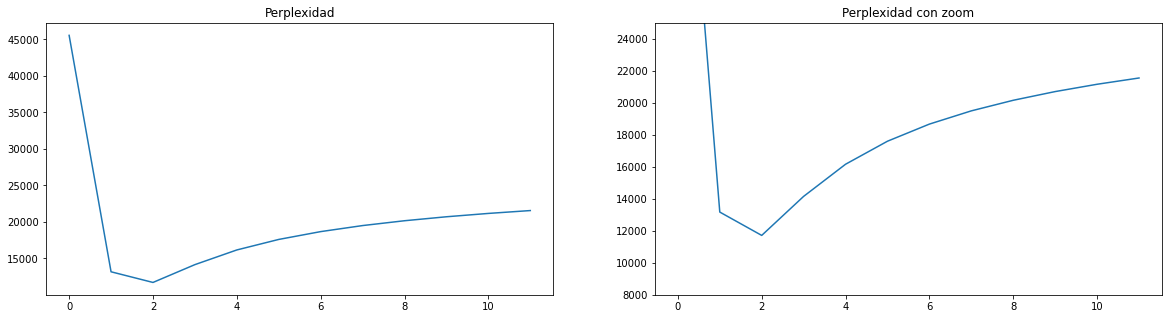

In [1119]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(perps)
plt.title('Perplexidad')

plt.subplot(122)
plt.plot(perps)
plt.ylim((8000,25000))
plt.title('Perplexidad con zoom')
plt.show()

Seleccionamos el lambda final para evaluar en los datos de test:

In [1120]:
test_trigr = []
start = dict_ind['<s>']
end = dict_ind['</s>']
for i in range(2, len(test)):
    if dict_ind[test[i-2]] == start:
        test_trigr += [('<s>', '<s>', test[i-1])]
    if dict_ind[test[i-1]] == end:
        test_trigr.append((test[i-2], '</s>', '</s>'))
    elif dict_ind[test[i-2]] != end:
        test_trigr.append((test[i-2], test[i-1], test[i]))
test_trigr += [(test[-2], '</s>', '</s>')]


Para clasificar, necesitamos calcular la probabilidad de ser agresivo:

In [1121]:
def probability(trigrams, lm=[]):
    '''
    Función de probabilidad para trigramas
    '''
    N = len(trigrams)
    probs = []
    ans = 1.
    for trigram in trigrams:
        p  = lm[0] * P_uni[trigram[2]]
        p += lm[1] * P_bigr((trigram[1],trigram[2]), freqBigr, freqUni, cond=True)
        p += lm[2] * P_trigr(trigram, freqTrigr, freqBigr, freqUni, cond=True)
        ans *= p
        if trigram[1]==trigram[2] and trigram[1]=='</s>':
            probs += [ans]
            ans = 1.
    return probs

In [1122]:
probs = probability(test_trigr, lm_f)

In [1123]:
y = np.zeros(len(probs))
m = np.percentile(probs, 85)
idx = probs >= m
y[idx] = 1

In [1125]:
accuracy = sum(y==val_y)/len(val_y)
print('Se logra una buena clasificación del: ', accuracy)

Se logra una buena clasificación del:  0.5714285714285714


Con dicha probabilidad logra clasificarse un 0.6 de buena clasificacion en tuits agrsivos y no agresivos:

#### 4.3 Tuitear
La estrategia para tuitear será generar palabras dada un bigrama o unigrama anterior de manera aleatoria dentro del top 5 de mejores respuestas, la estrategia para aumentar la probabilidad de terminar el tuit cerca de las 50 palabras es poner el token de terminación si este aparece en el top 5

In [1205]:
def tuitear(tuit=[]):
    '''
    Función que produce un tuit generando de manera aleatoria posibles trigramas
    '''
    for i in range(50):
        word, top = autocomplete_and_candidates2(tuit, freqUni, lm_f)
        # random
        pos = int(np.random.rand()*len(top))
        count = 0
        #Probabilidad de paro
        if i > 45:
            if '</s>' in top:
                tuit += ['</s>']
                break
        for p in top:
            if count == pos:
                tuit += [top[p]]
                break
            count += 1
        if tuit[-1] == '</s>':
            break
    print(top)
    return tuit

def autocomplete_and_candidates2(sentence, vocabulary, lm):
    '''
    input_text: a text represented as a word list
    Returns: a list with suggested autocomplete
    '''
    corrected = []
    top = {-5 : '', -4 : '', -3 : '', -2 : '', -1 : ''} 
    if len(sentence) > 1:
        corrected = [sentence[-2], sentence[-1]]
        for word in vocabulary:
            autoc, prob = bestCandidate4(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    elif len(sentence) > 0:
        corrected = [sentence[0]]
        for word in vocabulary:
            autoc, prob = bestCandidate4(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    else:
        corrected = []
        for word in vocabulary:
            autoc, prob = bestCandidate4(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    return sentence + [top[max(top)]], top

def bestCandidate4(cand, sentence, lm):
    '''
    Elige el mejor candidato dada la ponderación de interpolación de lambda.
    '''
    p_max = 0
    best_cand = ''
    if len(sentence) > 1:
        #for cand in candidates:
        trigram = (sentence[-2], sentence[-1], cand)
        bigram = (sentence[-1], cand)
        p = interpolation(trigram, lm)
        if p > p_max:
            p_max = p
            best_cand = cand
    elif len(sentence) > 0:
        #for cand in candidates:
        bigram = (sentence[-1], cand)
        p = P_bigr(bigram, freqBigr, freqUni, cond=True)
        if p > p_max:
            p_max = p
            best_cand = cand
    else:
        #for cand in candidates:
        p = P_uni[cand]
        if p > p_max:
            p_max = p
            best_cand = cand
    
    return best_cand, p_max

Ejemplos:

In [1203]:
tuitear()

{0.04904386623707999: '<s>', 0.029724166604148058: 'de', 0.03060554147094211: 'que', 0.04903912028500655: '</s>', 0.02313906250322629: 'a'}


['que', 'me', 'de', 'la', '<s>', '</s>']

In [1204]:
tuitear(['hola'])

{0.04904386623708977: '<s>', 0.029724166604480448: 'de', 0.030605541472584506: 'que', 0.04903912028500655: '</s>', 0.023139062504330996: 'a'}


['hola', 'pinche', '<s>', 'a', 'la', 'que', '<s>', '<s>', '</s>']

#### 4.4 Conferencias AMLO
La estrategia será similar al de tuitear, sin embargo para que dure más la conferencia, se evitará poner el token de final hasta las 290 palabras.

Lectura y entrenamiento:

In [1210]:
import nltk
import glob
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.text import Text
from nltk.tokenize import TweetTokenizer 
from datetime import datetime
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [1222]:
str_conf = []
# Tokenizador con expresion regular solo para letras mayúsculas o minúsculas
tokenizer = RegexpTokenizer('[^\d\W]+|[\x2E]')

# Ciclo para abrir todos los archivos de las conferencias
for f_page in glob.glob('./corpus/*'):
    conf_i = open(f_page, 'r', encoding='utf-8').read().lower()
    # Separamos la conferencia i por palabras separadas por espacio
    conf_s = tokenizer.tokenize(conf_i)
    # Agregamos a la lista de conferencias
    str_conf += conf_s

# Descargamos los datos de la lista a un Text
text_conf = Text(str_conf)

In [1306]:
train = ['<s>']
for i in range(len(str_conf)):
    if str_conf[i] == '.':
        train += ['</s>', '<s>'] 
    else:
        train += [str_conf[i]]
train = train[:-1] #+ ['<unk>']*25

In [1307]:
v = sort_freq_dict(Counter(train)) 
V = v[:10000]
V = v

dict_ind = {}
dict_ind_inv = {}
count = 0
for _, word in V:
    dict_ind[word] = count
    dict_ind_inv[count] = word
    count += 1

In [1276]:
#dict_ind['<unk>'] = 10000
#dict_ind_inv[10000] = '<unk>'

In [1308]:
#for i in range(len(train)):
 #   if not (train[i] in dict_ind):
  #      train[i] = '<unk>'

In [1309]:
freqUni = Counter(train)

In [1310]:
P_uni = {}
N = len(train)
len_V = len(V)
for frec, word in V:
    P_uni[word] = (frec+1) / (N+len_V)

In [1311]:
bigrams = [('<s>', '<s>')]
end = dict_ind['</s>']
for i in range(1, len(train)):
    #if dict_ind[corpus[i-1]] != end:
    bigrams.append((train[i-1], train[i]))
bigrams += [('</s>', '</s>')]

In [1312]:
freqBigr = Counter(bigrams)

In [1313]:
trigrams = [('<s>', '<s>', '<s>')]
start = dict_ind['<s>']
end = dict_ind['</s>']
for i in range(2, len(train)):
    if dict_ind[train[i-2]] == start:
        trigrams += [('<s>', '<s>', train[i-1])]
    if dict_ind[train[i-1]] == end:
        trigrams.append((train[i-2], '</s>', '</s>'))
    elif dict_ind[train[i-2]] != end:
        trigrams.append((train[i-2], train[i-1], train[i]))
trigrams += [('</s>', '</s>', '</s>')]

In [1314]:
freqTrigr = Counter(trigrams)

Función de dar conferencia:

In [1315]:
def dar_conferencia(tuit=[]):
    '''
    Función que produce un tuit generando de manera aleatoria posibles trigramas
    '''
    for i in range(300):
        word, top = autocomplete_and_candidates3(tuit, freqUni, lm_f)
        
        #Probabilidad de paro
        if i > 290:
            if '</s>' in top:
                tuit += ['</s>']
                break
        # random
        pos = int(np.random.rand()*len(top))
        count = 0
        for p in top:
            if count == pos:
                if top[p] == '</s>':
                    tuit = word
                else:
                    tuit += [top[p]]
                break
            count += 1
        if tuit[-1] == '</s>':
            break
    return tuit

def autocomplete_and_candidates3(sentence, vocabulary, lm):
    '''
    input_text: a text represented as a word list
    Returns: a list with suggested autocomplete
    '''
    corrected = []
    top = {-5 : '', -4 : '', -3 : '', -2 : '', -1 : ''} 
    if len(sentence) > 1:
        corrected = [sentence[-2], sentence[-1]]
        for word in vocabulary:
            autoc, prob = bestCandidate5(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    elif len(sentence) > 0:
        corrected = [sentence[0]]
        for word in vocabulary:
            autoc, prob = bestCandidate5(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    else:
        corrected = []
        for word in vocabulary:
            autoc, prob = bestCandidate5(word, corrected, lm)
            pos = min(top)
            if prob > pos:
                top.pop(pos)
                top[prob] = autoc
    return sentence + [top[max(top)]], top

def bestCandidate5(cand, sentence, lm):
    '''
    Elige el mejor candidato dada la ponderación de interpolación de lambda.
    '''
    p_max = 0
    best_cand = ''
    if len(sentence) > 1:
        #for cand in candidates:
        trigram = (sentence[-2], sentence[-1], cand)
        bigram = (sentence[-1], cand)
        p = P_trigr(trigram, freqTrigr, freqBigr, freqUni, cond=True)
        if p > p_max:
            p_max = p
            best_cand = cand
        p = P_bigr(bigram, freqBigr, freqUni, cond=True)
        if p > p_max:
            p_max = p
            best_cand = cand
    elif len(sentence) > 0:
        #for cand in candidates:
        bigram = (sentence[-1], cand)
        p = P_bigr(bigram, freqBigr, freqUni, cond=True)
        if p > p_max:
            p_max = p
            best_cand = cand
    else:
        #for cand in candidates:
        p = P_uni[cand]
        if p > p_max:
            p_max = p
            best_cand = cand
    
    return best_cand, p_max

In [1316]:
dar_conferencia()

['que',
 'no',
 'hay',
 'que',
 'no',
 'hay',
 'que',
 'no',
 'es',
 'un',
 'asunto',
 'que',
 'no',
 'hay',
 'que',
 'no',
 'hay',
 'un',
 'asunto',
 'de',
 'los',
 'estados',
 'unidos',
 'y',
 'que',
 'se',
 'está',
 'el',
 'que',
 'se',
 'va',
 'a',
 'la',
 'corrupción',
 'y',
 'en',
 'el',
 'gobierno',
 'de',
 'los',
 'trabajadores',
 'de',
 'la',
 'gente',
 'de',
 'méxico',
 '</s>']